<a href="https://colab.research.google.com/github/Mehrads/NLP-method/blob/main/nlp_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Data/Suicide_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
data["Unnamed: 0"].value_counts().max()

1

In [5]:
data["class"].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

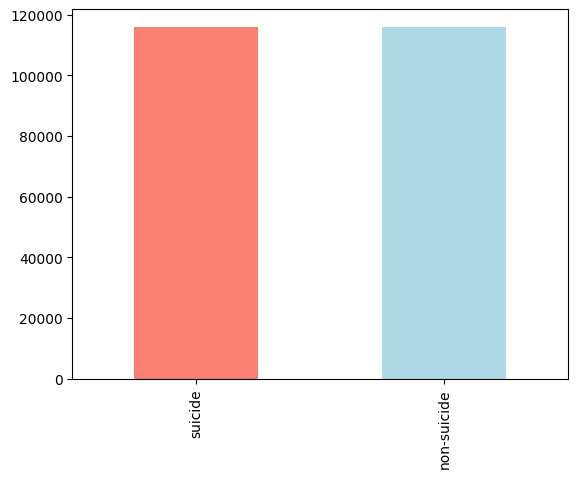

In [6]:
data["class"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [7]:
data = data.drop("Unnamed: 0", axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [8]:
data["text"][1]

"Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it"

In [9]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42)

In [10]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        #sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [11]:
np.random.seed(42)
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:02<00:00, 16301.70it/s]


In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [13]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

In [14]:
word_freq.iloc[:30]

,word,count
11,im,262218
3,dont,170780
114,like,144424
139,want,119519
4,know,104463
348,feel,97903
126,life,93692
9,ive,83425
20,cant,81579
57,people,73812


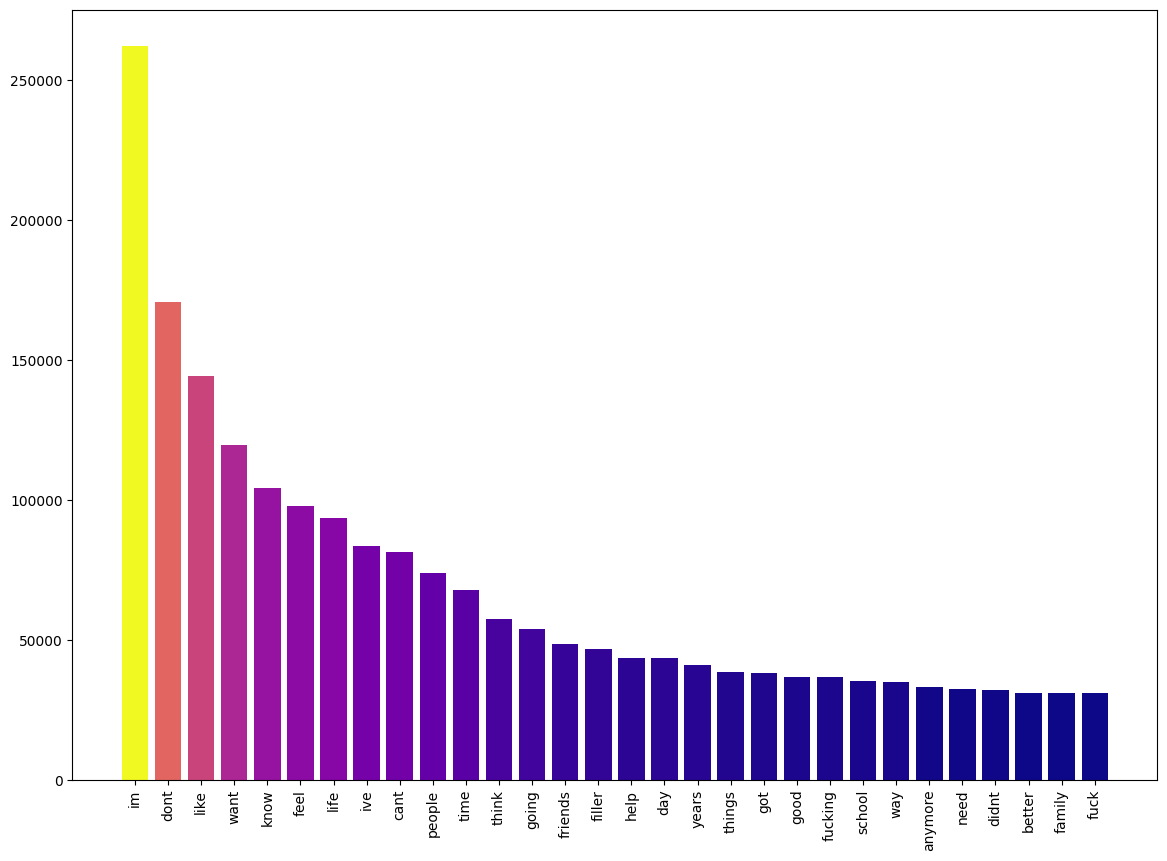

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
my_cmap = plt.get_cmap("plasma")
y = word_freq["count"].iloc[:30]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
ax.bar(x=word_freq["word"].iloc[:30], height=word_freq["count"].iloc[:30], color=my_cmap(rescale(y)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

In [16]:
np.random.seed(42)
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [17]:
np.random.seed(42)
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [18]:
with open('/content/drive/MyDrive/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [19]:
np.random.seed(42)
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [20]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [21]:
np.random.seed(42)

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            # This Dense layer's units will be dynamically set in the call method
            tf.keras.layers.Dense(head_size),  # Placeholder, will adjust dynamically
        ])
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        # Dynamically set the output dimension of the last Dense layer to match input dimension
        self.ffn.layers[-1].units = inputs.shape[-1]
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)


# Define your model architecture here
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,)),
    tf.keras.layers.Embedding(v+1, 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(20, return_sequences=True),
    TransformerEncoder(head_size=128, num_heads=4, ff_dim=512, dropout=0.1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.09),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [22]:
np.random.seed(42)
hybrid_model = model.fit(train_text_pad, train_output,
              validation_data=(test_text_pad, test_output),
              epochs=20,
              batch_size=256,
              callbacks=[early_stop, reducelr])

Epoch 1/20
726/726 [==============================] - 650s 890ms/step - loss: 0.3428 - accuracy: 0.8545 - val_loss: 0.3671 - val_accuracy: 0.8362 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 661s 911ms/step - loss: 0.2471 - accuracy: 0.9006 - val_loss: 0.2289 - val_accuracy: 0.9089 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 699s 963ms/step - loss: 0.2257 - accuracy: 0.9097 - val_loss: 0.2194 - val_accuracy: 0.9147 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 696s 960ms/step - loss: 0.2137 - accuracy: 0.9156 - val_loss: 0.2078 - val_accuracy: 0.9201 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 654s 901ms/step - loss: 0.2034 - accuracy: 0.9204 - val_loss: 0.2041 - val_accuracy: 0.9195 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 687s 946ms/step - loss: 0.1888 - accuracy: 0.9262 - val_loss: 0.2256 - val_accuracy: 0.9097 - lr: 0.1000
Epoch 7/20
726/726 [==========================

Saving our model

In [26]:
saved_model = model.save('/content/drive/MyDrive/Model/hybrid_model.h5')

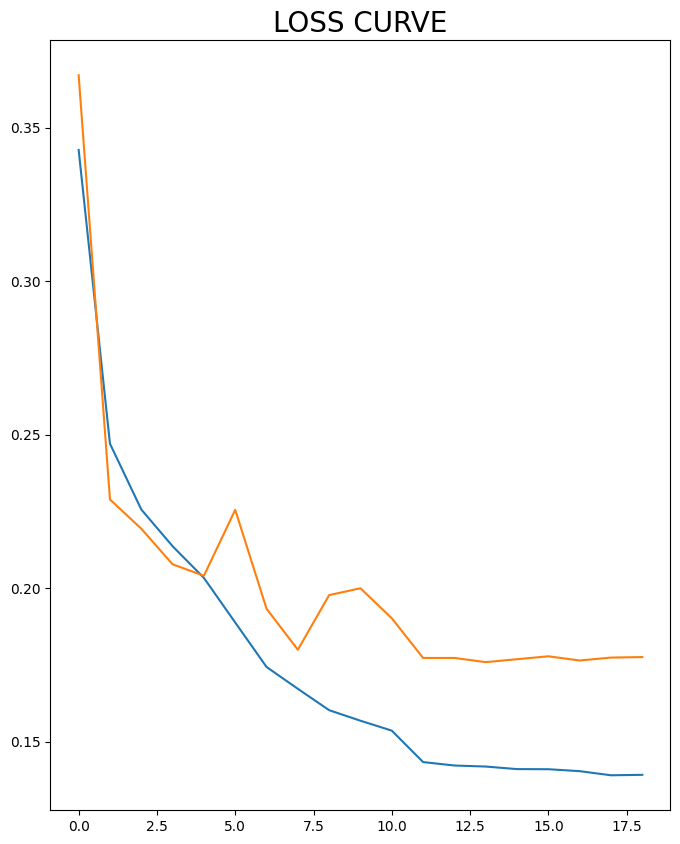

In [27]:
plt.figure(figsize=(8,10))
plt.plot(hybrid_model.history['loss'])
plt.plot(hybrid_model.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [33]:
predictions_test = (model.predict(test_text_pad) > 0.5).astype(int)
predictions_train = (model.predict(train_text_pad) > 0.5).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,predictions_test,
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,predictions_train,
                           target_names=lbl_target.inverse_transform([0,1])))

5802/5802 [==============================] - 227s 39ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.93     23287
     suicide       0.94      0.93      0.93     23128

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.95      0.94      0.95     92750
     suicide       0.94      0.96      0.95     92909

    accuracy                           0.95    185659
   macro avg       0.95      0.95      0.95    185659
weighted avg       0.95      0.95      0.95    185659

